# (E5) 프로젝트: Spectrogram classification 모델 구현

사람이 말하는 단어를 인공지능 모델로 구분하는 프로젝트입니다. 

- 소리 데이터를 입력받아 text 라벨로 출력하는 모델을 구성할 것입니다. 
- 입력 받는 데이터는 1차원 waveform이 아닌 2차원 spectrogram 데이터입니다.

## 1. 데이터 불러오기

In [2]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

wave 데이터는 npz 파일로 이뤄진 데이터이며, 각각 데이터는 "wav_vals", "label_vals"로 저장되어있습니다.  

- 데이터셋은 1초 길이의 오디오 음성데이터 50620개로 이뤄져 있습니다.
- 주어진 데이터의 원래 Sample rate는 16000이지만, 8000으로 re-sampling해 사용하겠습니다.

In [3]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [4]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  5162
Wave data shape :  (8000,)
label :  ['left']


랜덤으로 선택된 단어를 출력하였습니다.

## 2. Train/Test 데이터셋 구성하기

### 2.1 라벨 데이터 처리하기

- 현재 단어의 정답은 Text 형태로 이뤄져있습니다.  
- 학습을 위해서 Text 데이터를 학습가능한 형태로 만들어줍니다.

In [5]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [6]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

### 2. 2 train/test data 분리

In [7]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.2,
                                                                shuffle=True)
print(train_wav)

[[ 3.6214625e-03  5.4678549e-03  7.2523241e-04 ...  2.9960987e-03
   2.4070556e-03 -1.5236037e-03]
 [ 3.1467765e-03  4.5870594e-03  5.7398819e-04 ...  3.1714907e-03
   2.7831993e-03 -1.4235266e-03]
 [-4.6994695e-03 -6.7158039e-03 -5.7555493e-03 ... -7.2882776e-03
  -6.8717897e-03 -6.8608960e-03]
 ...
 [-7.6791468e-05 -2.1974195e-04  1.9540601e-04 ... -4.8722327e-04
   8.1289618e-05 -1.8255643e-05]
 [ 3.2339261e-03  4.3510138e-03 -4.3708345e-04 ...  2.2398666e-03
   1.6735272e-03 -2.1873354e-03]
 [ 2.1103902e-04 -3.0167064e-05 -6.4716086e-04 ... -1.6356500e-02
  -1.5282406e-02 -1.5220524e-02]]


In [8]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (40496, 8000)
train labels :  (40496,)
test data :  (10124, 8000)
test labels :  (10124,)


## 3. 학습을 위한 하이퍼파라미터 설정

In [9]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj22/aiffel/speech_recognition/models/wav'

## 4. 데이터셋 구성

- tf.data.Dataset을 이용
- from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
- map과 batch를 이용한 데이터 전처리
- 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
- tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.

In [10]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [11]:
train_spec = []

for wav in train_wav:
    train_spec.append(wav2spec(wav))

train_spec = np.array(train_spec)

print("train wav : ",train_wav.shape)
print("train spec : ",train_spec.shape)

train wav :  (40496, 8000)
train spec :  (40496, 130, 126)


In [12]:
test_spec = []

for wav in test_wav:
    test_spec.append(wav2spec(wav))


test_spec = np.array(test_spec)

print("test wav : ",test_wav.shape)
print("test spec : ",test_spec.shape)

test wav :  (10124, 8000)
test spec :  (10124, 130, 126)


### 4.1 spectrogram 출력

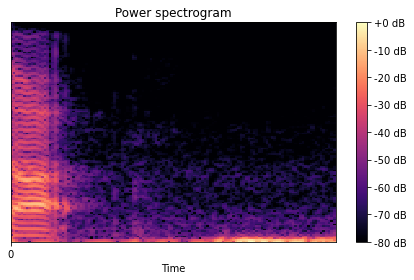

In [13]:
import librosa.display
import matplotlib.pyplot as plt

librosa.display.specshow(librosa.amplitude_to_db(test_spec[0], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

### 4.2 1d -> 2d 변환

In [14]:
sr = train_spec.shape[1]
sc = train_spec.shape[2]

train_spec = train_spec.reshape([-1,sr, sc, 1]) # add channel for CNN
test_spec = test_spec.reshape([-1,sr, sc, 1])

print(train_spec.shape)
print(test_spec.shape)

(40496, 130, 126, 1)
(10124, 130, 126, 1)


In [15]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [16]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


메모리 버퍼 지우기

In [17]:
del speech_data

## 5. 2차원 Spectrogram 데이터를 처리하는 모델 구성

- 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
- batchnorm, dropout, dense layer 등을 이용
- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
- 모델 가중치를 저장하는 checkpoint callback 함수 추가
- 다양한 모델의 실험을 진행해 보시기 바랍니다.

### 5.1 Conv2D layer 적용

In [18]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, sc, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

# x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
# x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
# x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(128)(x) # 256 -> 128
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0     

In [19]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

### 5.2 Training

In [20]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [21]:
history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1265/1265 [==============================] - ETA: 0s - loss: 0.7361 - accuracy: 0.7681
Epoch 00001: val_loss improved from inf to 0.29359, saving model to /home/aiffel-dj22/aiffel/speech_recognition/models/wav
1265/1265 [==============================] - 145s 115ms/step - loss: 0.7361 - accuracy: 0.7681 - val_loss: 0.2936 - val_accuracy: 0.9094
Epoch 2/10
1265/1265 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9236
Epoch 00002: val_loss improved from 0.29359 to 0.21921, saving model to /home/aiffel-dj22/aiffel/speech_recognition/models/wav
1265/1265 [==============================] - 140s 111ms/step - loss: 0.2529 - accuracy: 0.9236 - val_loss: 0.2192 - val_accuracy: 0.9306
Epoch 3/10
1265/1265 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9506
Epoch 00003: val_loss improved from 0.21921 to 0.20278, saving model to /home/aiffel-dj22/aiffel/speech_recognition/models/wav
1265/1265 [==============================] - 148s 117ms

## 6. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력학습 결과 Plot

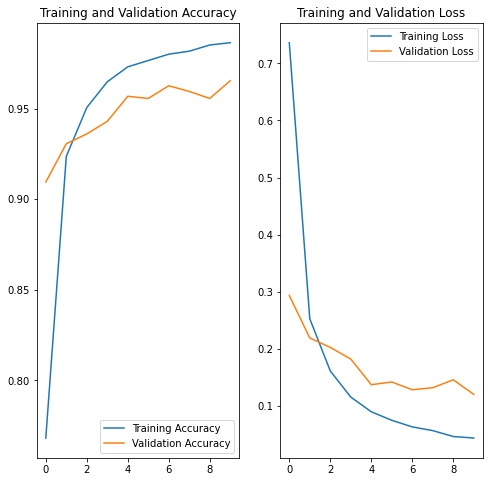

In [22]:
acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- epoch이 커질수록 training accuracy와 validation accuracy 증가합니다.
- epoch이 커질수록 training loss와 validation loss 감소합니다.

## 7. Test dataset을 이용해서 모델의 성능을 평가

### 7.1 Evaluation

In [23]:
model_spec.load_weights(checkpoint_dir)

In [24]:
results = model_spec.evaluate(test_dataset)

317/317 [==============================] - 22s 68ms/step - loss: 0.1204 - accuracy: 0.9654


In [25]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.120
accuracy value: 96.5429%


### 7.2 Model Test

In [26]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_spec(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

label :  go


In [27]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

y_pred: go(Correct!)


메모리 지우기

In [19]:
del speech_data

## 8. Skip-Connection model 추가

In [21]:
from tensorflow.keras import layers
input_tensor = layers.Input(shape=(sr, sc, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 130, 126, 32) 2624        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 130, 126, 32) 82976       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 63, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Optimizer

In [23]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

### 모델 가중치를 저장하는 checkpoint callback 함수 추가

In [24]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

### Training

In [25]:
history_spec_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
1265/1265 [==============================] - ETA: 0s - loss: 0.7532 - accuracy: 0.7563
Epoch 00001: val_loss improved from inf to 0.27572, saving model to /home/aiffel-dj22/aiffel/speech_recognition/models/wav_skip
1265/1265 [==============================] - 195s 154ms/step - loss: 0.7532 - accuracy: 0.7563 - val_loss: 0.2757 - val_accuracy: 0.9115
Epoch 2/10
1265/1265 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9303
Epoch 00002: val_loss improved from 0.27572 to 0.19774, saving model to /home/aiffel-dj22/aiffel/speech_recognition/models/wav_skip
1265/1265 [==============================] - 196s 155ms/step - loss: 0.2200 - accuracy: 0.9303 - val_loss: 0.1977 - val_accuracy: 0.9340
Epoch 3/10
1265/1265 [==============================] - ETA: 0s - loss: 0.1420 - accuracy: 0.9542
Epoch 00003: val_loss improved from 0.19774 to 0.14429, saving model to /home/aiffel-dj22/aiffel/speech_recognition/models/wav_skip
1265/1265 [=============================

### 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력학습 결과 Plot

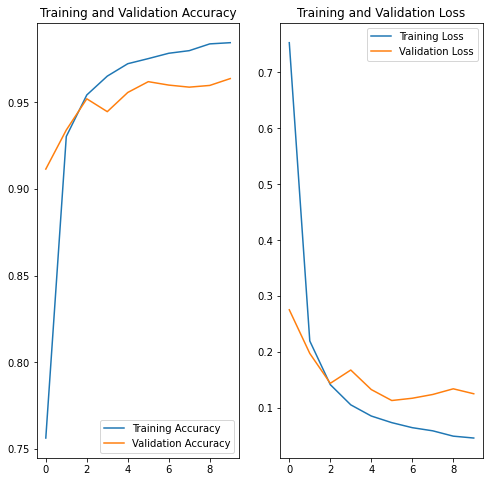

In [28]:
acc = history_spec_skip.history['accuracy']
val_acc = history_spec_skip.history['val_accuracy']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- epoch이 커질수록 training accuracy와 validation accuracy 증가합니다.
- epoch이 커질수록 training loss와 validation loss 감소합니다.

### Test dataset을 이용해서 모델의 성능을 평가

In [31]:
# Evaluation 
model_spec_skip.load_weights(checkpoint_dir)
results = model_spec_skip.evaluate(test_dataset)
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

317/317 [==============================] - 12s 37ms/step - loss: 0.1134 - accuracy: 0.9620
loss value: 0.113
accuracy value: 96.1972%


In [36]:
# Test 
y_pred_ = model_spec_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')

label :  go
y_pred: go(Correct!)


## 9. 평가

1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.

스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상 진행되었습니다. 전체 데이터의 20%를 테스트 데이터로 설정하고 훈련데이터와 분리하였습니다.

- train data :  (40496, 8000)
- train labels :  (40496,)
- test data :  (10124, 8000)
- test labels :  (10124,)

2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.

스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능합니다. 

- epoch이 커질수록 training accuracy와 validation accuracy 증가합니다.
- epoch이 커질수록 training loss와 validation loss 감소합니다.

3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.

evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.

- 기본 model - accuracy value: 96.5429%
- skip connection model - accuracy value: 96.1972%

두 모델 모두 정확도가 96%가 넘는 성능을 보입니다.

- waveform을 spectrogram으로 변환할 때 사용되는 메모리 때문에 이후 메모리 부족 현상을 겪었는데, del 함수를 사용하여 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주니 모델이 안정적으로 학습할 수 있었습니다.

- SGD 방법을 사용하여 GD 방법보다 학습 시간을 빠르게 할 수 있었지만, 여전히 이 모델의 학습 속도가 느리기 때문에 step size를 직접 변경하며 결정하는 것은 어려운 문제입니다.

- 음성 데이터를 처리하는 것은 이미지나 자연어 처리와는 또 다른 방법이라서 개념적으로 이해하지 못하고 진행하여서 공부할 것이 많게 느껴졌습니다.